In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import time

In [2]:
!python -V

Python 3.6.10 :: Anaconda, Inc.


In [3]:
np.__version__, pd.__version__, mpl.__version__

('1.16.3', '0.24.2', '3.0.3')

In [4]:
np.set_printoptions(suppress=True)

In [5]:
def author():
    """  		  	   		 	   			  		 			     			  	 
    :return: The GT username of the student  		  	   		 	   			  		 			     			  	 
    :rtype: str  		  	   		 	   			  		 			     			  	 
    """
    return "mshihab6"  # replace tb34 with your Georgia Tech username.


def gtid():
    """  		  	   		 	   			  		 			     			  	 
    :return: The GT ID of the student  		  	   		 	   			  		 			     			  	 
    :rtype: int  		  	   		 	   			  		 			     			  	 
    """
    return 903687444  # replace with your GT ID number


def get_spin_result(win_prob):
    """  		  	   		 	   			  		 			     			  	 
    Given a win probability between 0 and 1, the function returns whether the probability will result in a win.  		  	   		 	   			  		 			     			  	 

    :param win_prob: The probability of winning  		  	   		 	   			  		 			     			  	 
    :type win_prob: float  		  	   		 	   			  		 			     			  	 
    :return: The result of the spin.  		  	   		 	   			  		 			     			  	 
    :rtype: bool  		  	   		 	   			  		 			     			  	 
    """
    result = False
    if np.random.random() <= win_prob:
        result = True
    return result

#  API Requirements above. Do Note Edit

In [6]:
def betting_strategy(win_probability):
    episode_winnings = 0
    winnings = np.full(shape=(1001,), fill_value=80)  # Will increment by 1 when win even after a series of losses
    # Therefore, it should always end in 80
    spin = 0
    while episode_winnings < 80:
        won = False
        bet_amount = 1
        while not won:
            if spin >= 1001:
                return winnings
            winnings[spin] = episode_winnings
            won = get_spin_result(win_probability)
            spin += 1
            if won:
                episode_winnings += bet_amount
            else:
                episode_winnings -= bet_amount
                bet_amount *= 2
    return winnings


def realistic_betting_strategy(win_probability: float, bankroll_amount: float = None):
    episode_winnings = 0
    winnings = np.full(shape=(1001,), fill_value=80)
    spin = 0
    while (episode_winnings < 80) and (episode_winnings > -bankroll_amount):
        won = False
        bet_amount = 1
        while not won:
            if spin >= 1001:
                # print("returning end")
                return winnings
            if episode_winnings <= -bankroll_amount:
                winnings[spin:] = episode_winnings
                # print("returning loss")
                return winnings
            winnings[spin] = episode_winnings
            won = get_spin_result(win_probability)
            spin += 1
            if won:
                episode_winnings += bet_amount
            else:
                episode_winnings -= bet_amount
                bet_amount = min(bet_amount * 2, bankroll_amount + episode_winnings)  # it is bankroll+episode_winnings
                # since the case where this will be relevant is when the episode_winnings will be < 0 and close to -256
    # print("returning win")
    return winnings


def experiment(num_episodes: int, win_probability: float, bankroll_problem: bool = False,
               bankroll_amount: float = None):
    episodes = np.zeros((num_episodes, 1001))
    for i in range(num_episodes):
        if bankroll_problem:
            episodes[i] = realistic_betting_strategy(win_probability, bankroll_amount=bankroll_amount)
        else:
            episodes[i] = betting_strategy(win_probability)
    return episodes

In [7]:
def aggregate_experiments(experiment_array: np.ndarray, aggregation: str = "mean"):
    if aggregation == "mean":
        return np.mean(experiment_array, axis=0)
    if aggregation == "median":
        return np.median(experiment_array, axis=0)
    if aggregation == "std":
        return np.std(experiment_array, axis=0)
    return experiment_array

In [60]:
def calculate_win_prob(experiment_array: np.ndarray):
    # Since the win condition is reaching 80, anything that isn't 80, is considered not a win
    loss_prob = (experiment_array[:, -1] < 80).sum() / len(experiment_array)
    win_prob = 1 - loss_prob
    return win_prob


def calculate_win_count(experiment_array: np.ndarray):
    win_count = (experiment_array[:, -1] == 80).sum()
    return win_count


def average_num_spins_to_win(experiment_array: np.ndarray):
    first_wins = np.array([])
    for arr in experiment_array:
        try:
            first_wins = np.append(first_wins, np.argwhere(arr == 80)[0][0])
        except IndexError:
            first_wins = np.append(first_wins, np.nan)
    return (np.round(np.nanmean(first_wins), 2),
            np.round(np.nanmedian(first_wins), 2),
            np.round(np.nanstd(first_wins), 2))


def calculate_below_threshold(experiment_array: np.ndarray, threshold: int = -256):
    experiment_array_min = np.min(experiment_array, axis=1)
    return len(np.where(experiment_array_min < threshold)[0])


def calculate_winnings_expectation(experiment_array: np.ndarray):
    expectation_array = np.unique(experiment_array[:, -1], return_counts=True)
    expectation = (expectation_array[0] * expectation_array[1] / expectation_array[1].sum()).sum()
    return expectation_array, expectation

In [ ]:
def create_experiment_plot(title: str, experiment_array: np.ndarray, agg: str = None, std: bool = False, xlim=(0, 300),
                           ylim=(-256, 100)):
    fig, ax = plt.subplots()
    # ax.set_xlim(0, 300)
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_xlabel("Spin Number")
    # ax.set_ylim(-256, 100)
    ax.set_ylim(ylim[0], ylim[1])
    ax.set_ylabel("Total Winnings")
    if agg is None:
        ax.set_title(f"Figure {title.split('_')[0]}: {len(experiment_array):,} Episodes")
        std = False
        for i, episode in enumerate(experiment_array):
            ax.plot(range(1001), episode, label=f"Episode {i}")
    if agg in ["mean", "median"]:
        ax.set_title(
            f"Figure {title.split('_')[0]}: {len(experiment_array):,} Episodes with {agg} aggregation. Win_Prob: {calculate_win_prob(experiment_array):.2f}")
        aggregated_array = aggregate_experiments(experiment_array, aggregation=agg)
        aggregated_array_mean = np.mean(aggregated_array)
        ax.plot(range(1001), aggregated_array, color="black", label="Experiment")
        ax.plot(range(1001), [aggregated_array_mean] * 1001, color="grey", linestyle=(0, (2, 5)),
                label=f"Average {agg} of Experiment: {aggregated_array_mean:.2f}")
        if std:
            std = aggregate_experiments(experiment_array, aggregation="std")
            ax.plot(range(1001), aggregated_array + std, color="black", linestyle="--")
            ax.plot(range(1001), aggregated_array - std, color="black", linestyle="--")
            ax.fill_between(range(1001), aggregated_array, aggregated_array + std, alpha=0.2, color="green")
            ax.fill_between(range(1001), aggregated_array, aggregated_array - std, alpha=0.2, color="red")
    ax.legend()
    plt.tight_layout()
    plt.show()

In [9]:
    win_prob = 0.4737
    # There are numbers from 1 to 36 (alternating in color based on a specific set of conditions)
    # and two green sections labeled 0 and 00. The odds of winning are 1 1/9 to 1 https://en.wikipedia.org/wiki/Roulette
    # Which when converted using https://www.covers.com/tools/odds-converter is around 47.37%
    # ~18/38 since there are 38 slots, and 18 are red, 18 are black, and 2 green (0 and 00)
    # What are the odds of hitting red or black in roulette? The odds of hitting red
    # or black in American roulette are 47.37%. https://www.casino.org/roulette/odds/
    np.random.seed(gtid())  # do this only once
    print(get_spin_result(win_prob))  # test the roulette spin
    # add your code here to implement the experiments
    

True


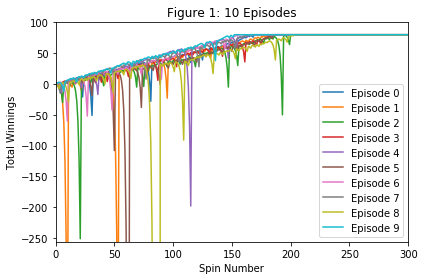

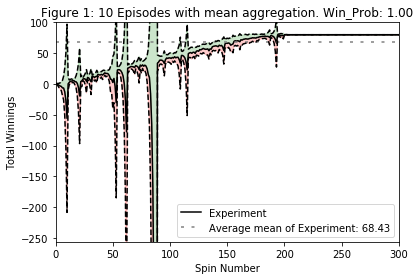

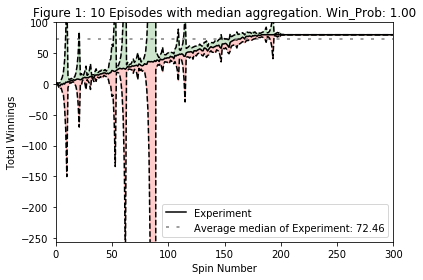

fig_1 complete


In [10]:
    ex1: np.ndarray = experiment(10, win_prob)
    create_experiment_plot("1", ex1, agg=None, std=False)
    create_experiment_plot("1_mean", ex1, agg="mean", std=True)
    create_experiment_plot("1_median", ex1, agg="median", std=True)
    print("fig_1 complete")    

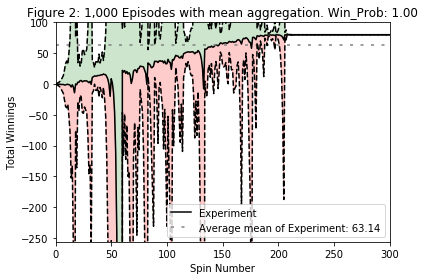

fig_2 complete


In [11]:
    ex2: np.ndarray = experiment(1_000, win_prob)
    create_experiment_plot("2", ex2, agg="mean", std=True)
    # create_experiment_plot("2_no_agg", ex2, agg=None, std=False) # Ignore, meant for sanity check
    # create_experiment_plot("2_mean_zoomout", ex2, agg="mean", std=True, ylim=(-4500,250)) # Ignore, meant for sanity check
    print("fig_2 complete")    

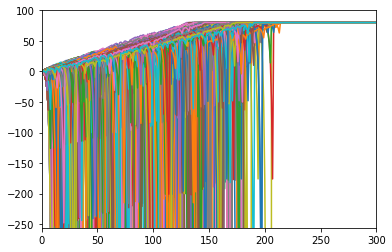

In [34]:
fig,ax = plt.subplots()
ax.set_xlim(0,300)
ax.set_ylim(-256,100)
for arr in ex2:
    ax.plot(range(len(arr)),arr)

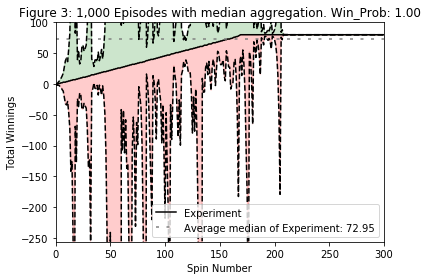

fig_3 complete


In [13]:
    create_experiment_plot("3", ex2, agg="median", std=True)
    print("fig_3 complete")

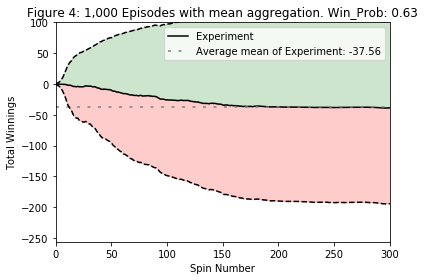

fig_4 complete


In [14]:
    ex4: np.ndarray = experiment(1_000, win_prob, bankroll_problem=True, bankroll_amount=256)
    create_experiment_plot("4", ex4, agg="mean", std=True)
    # create_experiment_plot("4_no_agg", ex4, agg=None, std=False) # Ignore, meant for sanity check
    # create_experiment_plot("4_mean_zoom", ex4, agg="mean", std=True, ylim=(-60,10)) # Ignore, meant for sanity check
    print("fig_4 complete")    

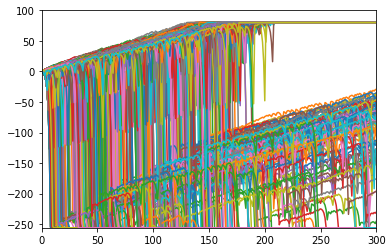

In [33]:
fig,ax = plt.subplots()
ax.set_xlim(0,300)
ax.set_ylim(-256,100)
for arr in ex4:
    ax.plot(range(len(arr)),arr)

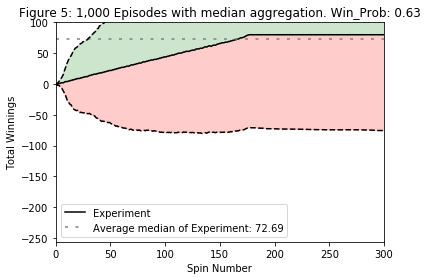

fig_5 complete


In [16]:
    create_experiment_plot("5", ex4, agg="median", std=True)
    print("fig_5 complete")

In [44]:
np.array([80]*633+[-256]*365+[45+67]).mean(),np.array([80]*633+[-256]*365+[45+67]).std()

(-42.730730730730734, 161.82237499064888)

In [45]:
-42.73+161.82, -42.73-161.82

(119.09, -204.54999999999998)

In [59]:
len(range(8,22,2))

7